In [478]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LsiModel, CoherenceModel
from gensim.models.ldamodel import LdaModel  # LDA single-core implementation 
from gensim import corpora, matutils
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.wrappers import LdaMallet 
from gensim import similarities
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import numpy as np
from pprint import pprint
import string
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=DeprecationWarning) 
from nltk import FreqDist
import operator
from functools import reduce 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Loading articles

In [3]:
pd.set_option("max_columns", 50)
pd.set_option('display.max_colwidth', -1)

# Load articles from csv file 
ccn = pd.read_csv('/home/irinakorchagina/Disruptive/ccn_reind.csv', sep = ";", index_col = 0)
        # ccn = ccn.sort_values(['date'], ascending=[False])
        ## creating new column for indexing
        # ccn['ind'] = range(0, len(ccn)); ccn['ind'] = ccn.index; ccn_reind = ccn.set_index('ind')

In [486]:
ccn[31:32]
        # cnn.to_csv('/home/irinakorchagina/Disruptive/ccn_reind.csv', encoding='utf-8', sep = ";")
        # ccn.columns.values

date  \
ind                        
31   2018-04-27 11:59:00   

                                                           title  \
ind                                                                
31   10% of Q1 Revenue: Cryptocurrency Mining Boosts AMD Profits   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          article  \
ind                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [413]:
title = ccn.iloc[[i],[1]].to_string(index=False, header = False)
article = ccn.iloc[[i],[2]].to_string(index=False, header = False)
all = title + ' ' + article
print(all)

South Korea Nears Mandating Regulations for Bitcoin Exchanges South Korean authorities are reportedly close to putting the final touches on regulations for bitcoin and cryptocurrency exchanges. The Financial Services Commission (FSC), South Korea’s financial regulator and authority, is outlining regulations that will mandate cryptocurrency exchanges to play by its rules. The regulator publicly revealed its intention to introduce regulations for bitcoin exchanges last year with a focus on regulatory and licensing parameters. “The government will push for the systemization of digital currency on a full scale in tandem with a global trend in the US., Japan and other countries,” said FSC chairman Yim Jong-yong at the time. Six months later, a lack of consensus among multiple Korean authorities, including the central bank and multiple governmental ministries, over a unified regulatory approach left the plan in limbo. As the end of the year nears, the FSC is reportedly close to pinning final

## Preprocessing articles for LDA

In [447]:
# Preprocessing: word tokenization - to lower case - remove punctuation - stopwords - lemmatization
all_articles_tok = []
    
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['say', 'said', 'ought','would', 'time', 'year', 'thing', 'day', 'etc', 'also', 
                  'could', 'however', 'since', 'one', 'two', 'even', 'still', 'see', 'today', 'around', 'much'])
    
for i in range(len(ccn)):
    title = ccn.iloc[[i],[1]].to_string(index=False, header = False)
    content = ccn.iloc[[i],[2]].to_string(index=False, header = False)
    article = title + ' ' + content
    article = article.replace('\\r\\r\\r\\n', '')
    article = article.replace("U.S", 'USA')
    article = article.replace("US", 'USA')
    article = article.replace("U.K", 'unitedkingdom')
    article = article.replace("u/", '')
    art_words = word_tokenize(article)
    art_words_l = [t.lower() for t in art_words if t.isalpha()]
    first_text_list_cleaned = [word for word in art_words_l if word not in stopwords]
    wordnet_lemmatizer = WordNetLemmatizer()
    # Lemmatize all tokens into a new list: lemmatized
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in first_text_list_cleaned]
    all_articles_tok.append(lemmatized)
    # Print the 10 most common tokens
    # print(bow_simple.most_common(10))

In [448]:
# Let's see what is most common words in ccn articles
all1 = reduce(operator.concat, all_articles_tok)

In [451]:
fdist1 = FreqDist(all1)
# once_appeared = sorted(w for w in set(all1) if fdist1[w] == 1)
fdist1.most_common(10)

[('bitcoin', 10197),
 ('cryptocurrency', 6483),
 ('market', 5281),
 ('exchange', 3696),
 ('price', 3464),
 ('cryptocurrencies', 3144),
 ('blockchain', 2882),
 ('trading', 2346),
 ('investor', 2231),
 ('bank', 2186)]

In [452]:
# What is in token which is one character lenght? 
sign = []

for w in all_articles_tok:
    for i in range(len(w)):
        token = w[i]
        if len(token) == 1:
            sign.append(token)
print(set(sign))

{'k', 'و', 'l', 'e', 'p', 'h', 'g', 'b', 'r', 'x', 'c', 'u', 'f', 'q', 'n', 'j', 'o', 'z', 'v', 'w'}


## Creating corpus

In [453]:
# Create a Dictionary from CCN articles: dictionary
dictionary = corpora.Dictionary(all_articles_tok)
# Create a gensim corpus
corpus = [dictionary.doc2bow(text) for text in all_articles_tok]
len(dictionary)
    # # Print the first 10 word ids with their frequency counts from the fifth document
    # print(corpus[4][:10])
    # # Select the id for "computer": computer_id
    # computer_id = dictionary.token2id.get("computer")

19456

In [446]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1111]]

[[('able', 1),
  ('abstract', 1),
  ('according', 2),
  ('addition', 1),
  ('allow', 1),
  ('application', 2),
  ('applied', 1),
  ('april', 1),
  ('associated', 1),
  ('begin', 1),
  ('beginning', 1),
  ('block', 6),
  ('blockchain', 14),
  ('blockchains', 2),
  ('computing', 3),
  ('configured', 2),
  ('consisting', 1),
  ('cryptocurrency', 1),
  ('data', 2),
  ('date', 1),
  ('david', 1),
  ('designed', 1),
  ('device', 1),
  ('digital', 1),
  ('efficient', 2),
  ('embodiment', 1),
  ('enable', 2),
  ('epoch', 1),
  ('facilitate', 1),
  ('fast', 5),
  ('faster', 2),
  ('file', 1),
  ('filed', 1),
  ('filing', 1),
  ('flag', 3),
  ('generated', 1),
  ('generation', 1),
  ('greatly', 1),
  ('guildford', 1),
  ('hash', 2),
  ('header', 2),
  ('improve', 1),
  ('included', 2),
  ('inclusion', 1),
  ('increase', 1),
  ('increased', 1),
  ('international', 1),
  ('inventor', 1),
  ('king', 1),
  ('kingdom', 1),
  ('large', 1),
  ('listed', 1),
  ('manipulation', 1),
  ('mastercard', 2),
 

In [489]:
# fit LDA model
lda_crypto = LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, passes=15)

In [490]:
# Compute Perplexity
# print(lda_crypto.log_perplexity(corpus, chunk = 50))  # measure how good the model (lower the better)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_crypto, texts=all_articles_tok, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4140013872561597


In [437]:
lda_crypto.show_topics(num_topics=20, num_words=8, log=False, formatted=True)

[(0,
  '0.033*"token" + 0.030*"ico" + 0.014*"company" + 0.013*"million" + 0.010*"investor" + 0.010*"sale" + 0.010*"sec" + 0.009*"telegram"'),
 (1,
  '0.024*"fund" + 0.022*"iota" + 0.013*"hedge" + 0.008*"samsung" + 0.007*"mining" + 0.006*"charity" + 0.006*"pineapple" + 0.005*"seed"'),
 (2,
  '0.033*"blockchain" + 0.018*"technology" + 0.008*"platform" + 0.007*"company" + 0.006*"token" + 0.006*"industry" + 0.006*"bank" + 0.006*"project"'),
 (3,
  '0.025*"exchange" + 0.014*"cryptocurrency" + 0.011*"new" + 0.011*"japan" + 0.007*"bank" + 0.007*"bitcoin" + 0.007*"fsa" + 0.007*"financial"'),
 (4,
  '0.009*"cryptocurrency" + 0.008*"bitcoin" + 0.008*"petro" + 0.007*"user" + 0.007*"mcafee" + 0.005*"exchange" + 0.005*"investor" + 0.005*"venezuela"'),
 (5,
  '0.010*"company" + 0.008*"cryptocurrency" + 0.005*"country" + 0.005*"bitcoin" + 0.005*"data" + 0.004*"user" + 0.004*"petro" + 0.004*"according"'),
 (6,
  '0.032*"future" + 0.027*"bitcoin" + 0.018*"exchange" + 0.012*"cboe" + 0.010*"contract" + 0

In [439]:
# LDA model visualisation
vis_data = gensimvis.prepare(lda_crypto, corpus, dictionary, R = 30)
pyLDAvis.display(vis_data)

In [499]:
# Checking similarities between documents; compare the third article in our corpus to all others articles
lda_index = similarities.MatrixSimilarity(lda_crypto[corpus])
vec_bow = dictionary.doc2bow(all_articles_tok[2])
vec_lda = lda_crypto[vec_bow]

sims = lda_index[vec_lda]
sims = sorted(enumerate(sims), key=lambda item: -item[1])
# Print first 8 similar id articles
print(sims[0:9])

[(2, 1.0), (1124, 0.9600608), (1129, 0.9382592), (992, 0.9305395), (405, 0.9257626), (1076, 0.9201292), (1218, 0.91569495), (542, 0.9116693), (1599, 0.9060806)]


In [394]:
# How to find the optimal number of topics for LDA?
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = '/home/irinakorchagina/mallet/mallet-2.0.8/bin/mallet' 
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [457]:
# Choosing optimal model with coherence score
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=all_articles_tok, start=10, limit=45, step=2)

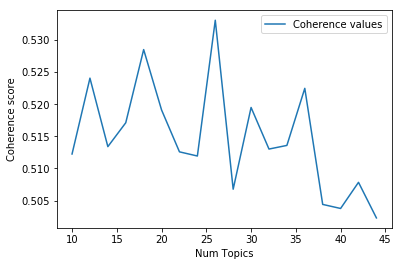

In [465]:
# Plot coherence values
limit=45; start=10; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values, label='Coherence values')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

In [459]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5122
Num Topics = 12  has Coherence Value of 0.5241
Num Topics = 14  has Coherence Value of 0.5134
Num Topics = 16  has Coherence Value of 0.5171
Num Topics = 18  has Coherence Value of 0.5285
Num Topics = 20  has Coherence Value of 0.5191
Num Topics = 22  has Coherence Value of 0.5126
Num Topics = 24  has Coherence Value of 0.5119
Num Topics = 26  has Coherence Value of 0.5331
Num Topics = 28  has Coherence Value of 0.5068
Num Topics = 30  has Coherence Value of 0.5195
Num Topics = 32  has Coherence Value of 0.513
Num Topics = 34  has Coherence Value of 0.5136
Num Topics = 36  has Coherence Value of 0.5225
Num Topics = 38  has Coherence Value of 0.5044
Num Topics = 40  has Coherence Value of 0.5038
Num Topics = 42  has Coherence Value of 0.5078
Num Topics = 44  has Coherence Value of 0.5023


In [472]:
# Select the model and print the topics
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(17,
  '0.020*"twitter" + 0.017*"medium" + 0.013*"facebook" + 0.013*"coin" + '
  '0.012*"post" + 0.011*"community" + 0.011*"crypto" + 0.011*"scam" + '
  '0.011*"claim" + 0.010*"social"'),
 (11,
  '0.092*"company" + 0.037*"million" + 0.033*"firm" + 0.018*"launch" + '
  '0.015*"app" + 0.015*"billion" + 0.014*"startup" + 0.013*"plan" + '
  '0.013*"share" + 0.012*"blockchain"'),
 (9,
  '0.144*"bitcoin" + 0.073*"price" + 0.018*"lee" + 0.016*"litecoin" + '
  '0.013*"end" + 0.011*"recent" + 0.011*"high" + 0.009*"rise" + 0.009*"buy" + '
  '0.009*"december"'),
 (8,
  '0.093*"currency" + 0.042*"money" + 0.039*"bitcoin" + 0.033*"digital" + '
  '0.031*"gold" + 0.024*"dollar" + 0.023*"fiat" + 0.015*"virtual" + '
  '0.014*"bank" + 0.014*"usa"'),
 (14,
  '0.043*"coinbase" + 0.026*"state" + 0.019*"crypto" + 0.018*"bill" + '
  '0.014*"cryptocurrency" + 0.014*"employee" + 0.012*"support" + '
  '0.012*"company" + 0.011*"account" + 0.009*"similar"'),
 (21,
  '0.054*"user" + 0.024*"account" + 0.023*"walle

In [401]:
# still need to be fixed --
# mallet_to_lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
# vis_data_malet_2 = gensimvis.prepare(mallet_to_lda, corpus, dictionary)
# pyLDAvis.display(vis_data_malet_2)


In [132]:
#Finding the dominant topic in each sentence

def format_topics_doc(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Sort tuples (topic_id, prob) in descending order 
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [172]:
optimal_model[corpus[9]]

[('payment', 0.06273914022057168),
 ('bank', 0.03786855728111636),
 ('ripple', 0.02312626603646185),
 ('service', 0.016486608147647984),
 ('card', 0.01614899842448796),
 ('transaction', 0.015811388701327932),
 ('customer', 0.015530047265361242),
 ('digital', 0.014629754670267838),
 ('company', 0.013391852352014405),
 ('purchase', 0.012716632905694351)]

In [473]:
# What is the dominant topic in each article?
df_topic_sents_keywords = format_topics_doc(ldamodel=optimal_model, corpus=corpus, texts=all_articles_tok)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0  0            15.0            0.3824               
1  1            15.0            0.2149               
2  2            11.0            0.2561               
3  3            5.0             0.4790               
4  4            7.0             0.2288               
5  5            19.0            0.1924               
6  6            12.0            0.1849               
7  7            7.0             0.4268               
8  8            10.0            0.4302               
9  9            15.0            0.2983               

                                                                                         Keywords  \
0  blockchain, technology, data, industry, system, ledger, world, digital, project, distributed     
1  blockchain, technology, data, industry, system, ledger, world, digital, project, distributed     
2  company, million, firm, launch, app, billion, startup, plan, share, blockchain                   
3  cryptocurrency, tax, country, government, petro, india, president, venezuela, russian, state     
4  exchange, cryptocurrency, japan, million, coincheck, japanese, financial, report, service, nem   
5  mining, miner, power, demand, operation, energy, rate, bitmain, electricity, supply              
6  people, money, make, good, problem, reason, point, question, case, data                          
7  exchange, cryptocurrency, japan, million, coincheck, japanese, financial, report, service, nem   
8  bitcoin, market, price, major, past, billion, percent, volume, global, week                      
9  blockchain, technology, data, industry, system, ledger, world, digital, project, distributed     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Text  
0  [mastercard, seek, patent, fast, tracking, blockchain, navigation, mastercard, international, applied, patent, system, fast, tracking, navigation, blockchains, mean, data, manipulation, according, filing, united, state, patent, trademark, office, system, designed, facilitate, quicker, navigation, verification, block, blockchain, david, j, king, guildford, united, kingdom, listed, inventor, system, patent, filed, publication, date, application, april, application, note, need, technical, solution, increase, speed, blockchain, navigated, verification, large, number, block, reduce, needed, new, node, begin, participating, blockchain, block, system, header, consisting, fast, track, flag, reference, timestamp, hash, value, use, specialized, flag, hash, value, included, block, header, allow, speed, navigation, increased, significantly, greatly, reduce, computing, power, needed, verify, blockchain, ...]                 
1  [comcast, venture, executive, real, value, bitcoin, blockchain, bitcoin, price, hovering, near, best, level, comcast, venture, managing, director, gil, beyda, say, people, realizing, real, value, bitcoin, blockchain, investor, focused, getting, rich, quick, money, froth, way, beyda, told, cnbc, think, pullback, okay, real, application, cryptocurrency, blockchain, technology, think, going, surge, people, really, understanding, poten

In [474]:
#Topic distribution across documents based on Mallet

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords = topic_num_keywords.sort_values('Dominant_Topic') 
topic_num_keywords['ind'] = range(0, len(topic_num_keywords))
topic_num_keywords = topic_num_keywords.set_index('ind')

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution*100], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.sort_values('Perc_Documents', ascending=False)

Dominant_Topic  \
6   6.0              
10  10.0             
0   0.0              
3   3.0              
5   5.0              
15  15.0             
1   1.0              
23  23.0             
19  19.0             
20  20.0             
17  17.0             
9   9.0              
21  21.0             
18  18.0             
4   4.0              
24  24.0             
2   2.0              
11  11.0             
25  25.0             
8   8.0              
7   7.0              
16  16.0             
13  13.0             
14  14.0             
12  12.0             
22  22.0             

                                                                                                     Topic_Keywords  \
6   percent, price, market, billion, cap, cryptocurrency, bitcoin, ethereum, ripple, top                              
10  bitcoin, market, price, major, past, billion, percent, volume, global, week                                       
0   bank, cryptocurrencies, central, financial, authority, regulation, currency, finance, country, risk               
3   cryptocurrency, south, korean, government, korea, trading, ban, exchange, china, local                            
5   cryptocurrency, tax, country, government, petro, india, president, venezuela, russian, state                      
15  blockchain, technology, data, industry, system, ledger, world, digital, project, distributed                      
1   security, ico, icos, token, sec, offering, investor, coin, initial, regulator                                     
23  payment, bank, ripple, card, customer, service, transaction, credit, transfer, purchase                           
19  mining, miner, power, demand, operation, energy, rate, bitmain, electricity, supply                               
20  court, scheme, case, bitcoins, law, money, investigation, activity, million, fraud                                
17  twitter, medium, facebook, coin, post, community, crypto, scam, claim, social                                     
9   bitcoin, price, lee, litecoin, end, recent, high, rise, buy, december                                             
21  user, account, wallet, address, security, access, key, fund, service, attack                                      
18  bitcoin, bubble, people, belief, interview, chief, world, recently, ceo, year                                     
4   bitcoin, future, exchange, contract, launch, product, cboe, trading, investor, market                             
24  bitcoin, transaction, cash, fee, network, user, fork, coin, support, block                                        
2   fund, investment, investor, capital, asset, million, hedge, crypto, traditional, invest                           
11  company, million, firm, launch, app, billion, startup, plan, share, blockchain                                    
25  token, platform, game, company, project, offer, service, sale, team, industry                                     
8   currency, money, bitcoin, digital, gold, dollar, fiat, virtual, bank, usa                                         
7   exchange, cryptocurrency, japan, million, coincheck, japanese, financial, report, service, nem                    
16  ethereum, network, decentralized, blockchain, project, development, developer, community, protocol, application   
13  exchange, trading, cryptocurrency, platform, trade, binance, trader, volume, announcement, largest                
14  coinbase, state, crypto, bill, cryptocurrency, employee, support, company, account, similar                       
12  people, money, make, good, problem, reason, point, question, case, data                                           
22  cryptocurrency, market, cryptocurrencies, investor, crypto, recent, month, high, volatility, asset                

    Num_Documents  Perc_Documents  
6   141            7.60            
10  133            7.17            
0   118            6.36            
3   100            5.39            
5   94         